In [1]:
import numpy as np
import pandas as pd

from molloader import *
from ML_utils import *

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split, KFold, ParameterGrid

In [2]:
def drop_duplicates(df):
    df = df.drop_duplicates(subset="compound", keep="first")
    print("Number of molecules", df.shape[0])
    return df

In [3]:
def get_all_elements(df):
      return np.unique(np.hstack(np.array(df.species)))

In [4]:
class VoxelNet(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # (N, C, D, H, W)
        self.conv1 = nn.Sequential(
            nn.Conv3d(in_channels, 16, 3, padding=0, stride=1),
            #nn.BatchNorm3d(16),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv2 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3),
            nn.MaxPool3d(2))
        
        self.conv3 = nn.Sequential(
            nn.Conv3d(16, 16, 3, padding=0, stride=1),
            nn.LeakyReLU(0.3))
        
        self.regressor = nn.Sequential(nn.Flatten(),
                                        nn.Linear(1024, 32),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(32, 8),
                                        nn.LeakyReLU(0.3),
                                        nn.Linear(8, 1))
    def forward(self, x):
        #print(x.shape)
        x = self.conv1(x)
        # print("conv1", x.shape)
        x = self.conv2(x)
        # print("conv2", x.shape)
        x = self.conv3(x)
        # print("conv3", x.shape)
        x = self.regressor(x)
        return x

In [5]:
df = pd.read_pickle("data/all_221_cp5_3_species_oxides.pkl")
df = drop_duplicates(df)
df

Number of molecules 1983


auid  \
0     aflow:b778fabdb1b01db1   
2     aflow:272cd0e74db84a51   
4     aflow:7e6bdbc495310b44   
6     aflow:c0e1c25976bb4c75   
8     aflow:3b79b8b28a5d5cc1   
...                      ...   
3947  aflow:e243d024b0749ac0   
3949  aflow:ae4a07b2d68c2933   
3951  aflow:0d9d3ce033a32aae   
3953  aflow:627232532ed2fb40   
3955  aflow:2b3ea96a80ac45cd   

                                                   aurl  compound composition  \
0     aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAlO/T00...  Ag1Al1O3   [1, 1, 3]   
2     aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAsO/T00...  Ag1As1O3   [1, 1, 3]   
4     aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgAuO/T00...  Ag1Au1O3   [1, 1, 3]   
6     aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgB_hO/T0...   Ag1B1O3   [1, 1, 3]   
8     aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/AgBa_svO/...  Ag1Ba1O3   [1, 1, 3]   
...                                                 ...       ...         ...   
3947  aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZn/T00...  O3Xe1Zn1   [3, 1, 1]   
3949  aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OXeZr_sv/...  O3Xe1Zr1   [3, 1, 1]   
3951  aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZn/T...   O3Y1Zn1   [3, 1, 1]   
3953  aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OY_svZr_s...   O3Y1Zr1   [3, 1, 1]   
3955  aflowlib.duke.edu:AFLOWDATA/LIB3_RAW/OZnZr_sv/...  O3Zn1Zr1   [3, 1, 1]   

          species natoms spacegroup pearson_symbol  \
0     [Ag, Al, O]      5        221            cP5   
2     [Ag, As, O]      5        221            cP5   
4     [Ag, Au, O]      5        221            cP5   
6      [Ag, B, O]      5        221            cP5   
8     [Ag, Ba, O]      5        221            cP5   
...           ...    ...        ...            ...   
3947  [O, Xe, Zn]      5        221            cP5   
3949  [O, Xe, Zr]      5        221            cP5   
3951   [O, Y, Zn]      5        221            cP5   
3953   [O, Y, Zr]      5        221            cP5   
3955  [O, Zn, Zr]      5        221            cP5   

                                               geometry  \
0     [3.7688035, 3.7688035, 3.7688035, 90.0, 90.0, ...   
2     [3.7951634, 3.7951634, 3.7951634, 90.0, 90.0, ...   
4     [4.1003175, 4.1003175, 4.1003175, 90.0, 90.0, ...   
6      [3.484261, 3.484261, 3.484261, 90.0, 90.0, 90.0]   
8     [4.7271734, 4.7271734, 4.7271734, 90.0, 90.0, ...   
...                                                 ...   
3947   [4.370543, 4.370543, 4.370543, 90.0, 90.0, 90.0]   
3949   [4.322477, 4.322477, 4.322477, 90.0, 90.0, 90.0]   
3951  [4.3517566, 4.3517566, 4.3517566, 90.0, 90.0, ...   
3953   [4.155165, 4.155165, 4.155165, 90.0, 90.0, 90.0]   
3955   [3.723766, 3.723766, 3.723766, 90.0, 90.0, 90.0]   

                                   positions_fractional  \
0     [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...   
2     [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...   
4     [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...   
6     [[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.0, 0.5, ...   
8     [[-0.0, 0.0, -0.0], [0.5, 0.5, 0.5], [-0.0, 0....   
...                                                 ...   
3947  [[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...   
3949  [[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...   
3951  [[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...   
3953  [[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...   
3955  [[0.0, 0.5, 0.5], [0.5, 0.0, 0.5], [0.5, 0.5, ...   

                                    positions_cartesian  enthalpy_atom  \
0     [[0.0, 0.0, 0.0], [1.8844, 1.8844, 1.8844], [0...       -5.04863   
2     [[0.0, 0.0, 0.0], [1.89758, 1.89758, 1.89758],...       -4.55519   
4     [[0.0, 0.0, 0.0], [2.05016, 2.05016, 2.05016],...       -2.80408   
6     [[0.0, 0.0, 0.0], [1.74213, 1.74213, 1.74213],...       -4.55549   
8     [[-0.0, 0.0, -0.0], [2.36359, 2.36359, 2.36359...       -3.52096   
...                                                 ...            ...   
3947  [[0.0, 2.18527, 2.18527], [2.18527, 0.0, 2.185...       -1.89960   
3949  [

In [6]:
elements = get_all_elements(df)
nchannel = len(elements)
nchannel, elements

(79,
 array(['Ag', 'Al', 'As', 'Au', 'B', 'Ba', 'Be', 'Bi', 'Br', 'C', 'Ca',
        'Cd', 'Ce', 'Cl', 'Co', 'Cr', 'Cs', 'Cu', 'Dy', 'Er', 'Eu', 'F',
        'Fe', 'Ga', 'Gd', 'Ge', 'Hf', 'Hg', 'Ho', 'I', 'In', 'Ir', 'K',
        'La', 'Li', 'Lu', 'Mg', 'Mn', 'Mo', 'N', 'Na', 'Nb', 'Nd', 'Ni',
        'O', 'Os', 'P', 'Pa', 'Pb', 'Pd', 'Pr', 'Pt', 'Pu', 'Rb', 'Re',
        'Rh', 'Ru', 'S', 'Sb', 'Sc', 'Se', 'Si', 'Sn', 'Sr', 'Ta', 'Tb',
        'Tc', 'Te', 'Th', 'Ti', 'Tl', 'U', 'V', 'W', 'Xe', 'Y', 'Yb', 'Zn',
        'Zr'], dtype='<U2'))

In [7]:
net = VoxelNet(nchannel)
count_parameters(net)

81073

## Parameter Grid Search

In [8]:
seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

(1784, 13) (199, 13)


In [9]:
param_grid = ParameterGrid({
    "sigma": [0.01, 0.1, 0.5, 1.],
    "L": [10, 12.8, 15],
    "weight_decay": [0., 0.001, 0.01]
})

In [10]:
len(list(param_grid))

36

0. L = 10, sigma = 0.01, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1538.6250s.                               


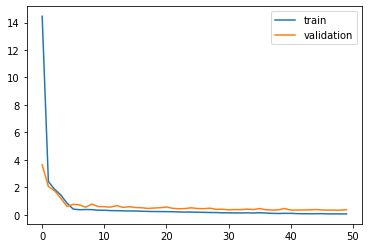

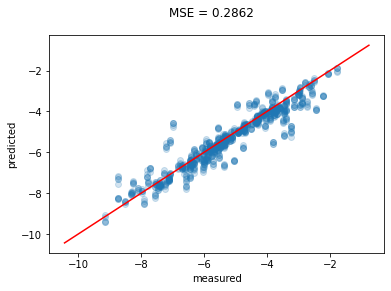

1. L = 10, sigma = 0.01, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1754.1527s.                               


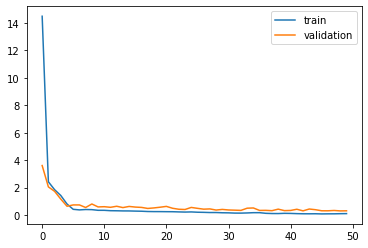

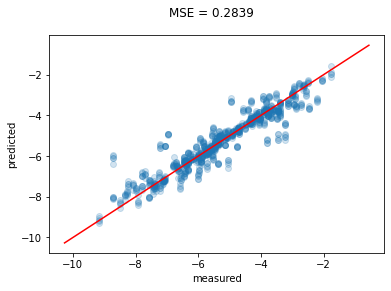

2. L = 10, sigma = 0.01, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1858.0528s.                               


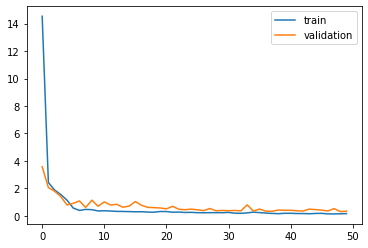

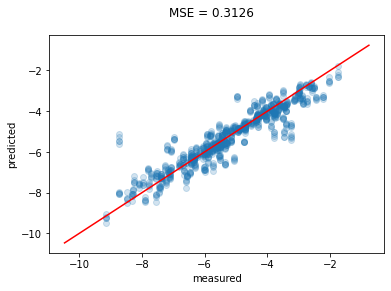

3. L = 10, sigma = 0.1, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1815.6739s.                               


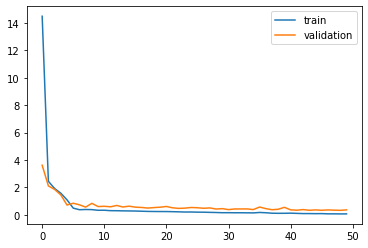

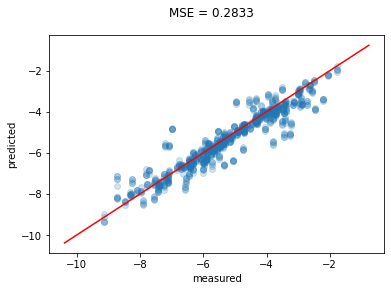

4. L = 10, sigma = 0.1, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1842.9963s.                               


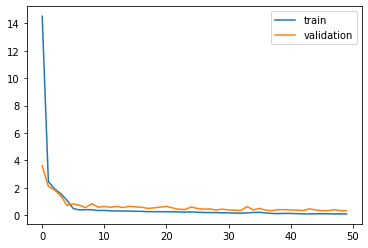

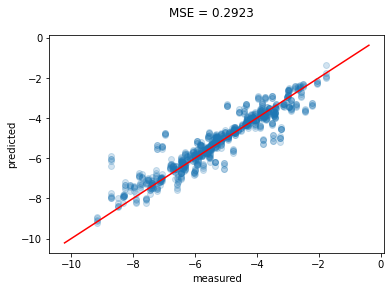

5. L = 10, sigma = 0.1, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1839.0985s.                               


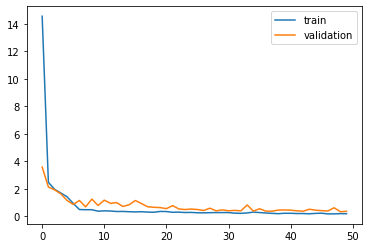

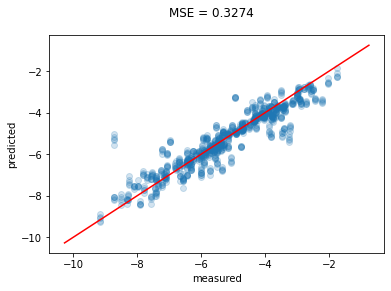

6. L = 10, sigma = 0.5, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1845.3730s.                               


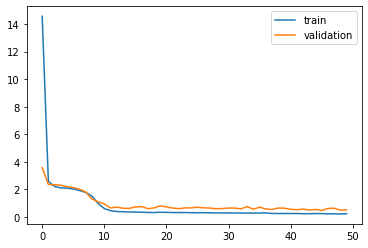

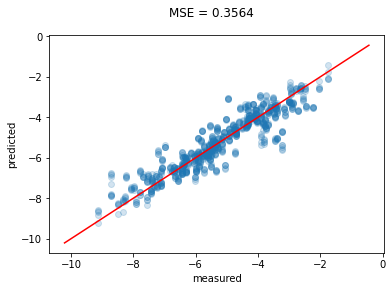

7. L = 10, sigma = 0.5, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1838.8566s.                               


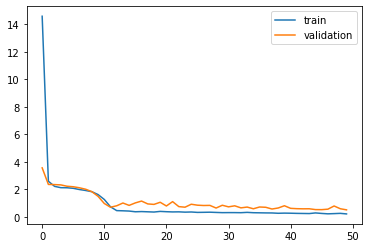

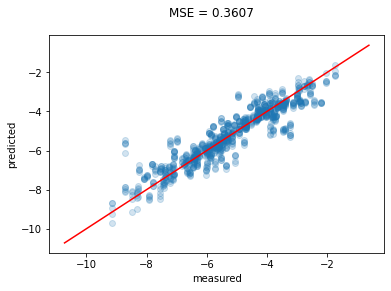

8. L = 10, sigma = 0.5, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1864.9826s.                               


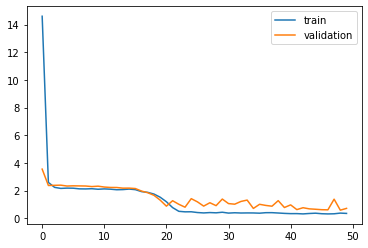

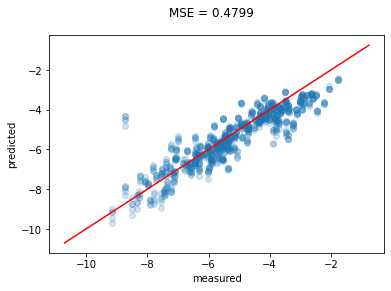

9. L = 10, sigma = 1.0, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1836.4951s.                               


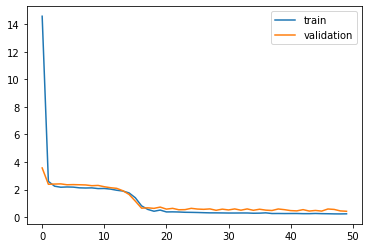

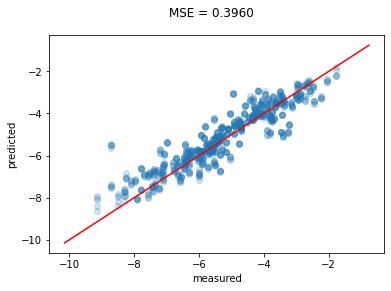

10. L = 10, sigma = 1.0, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1844.1122s.                               


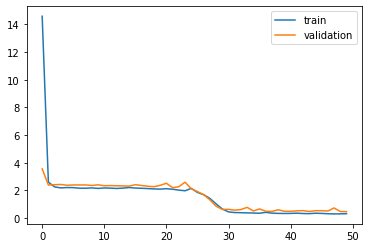

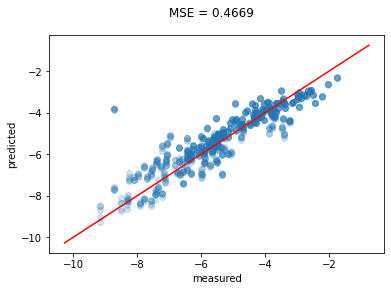

11. L = 10, sigma = 1.0, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=10, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=10, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1854.6788s.                               


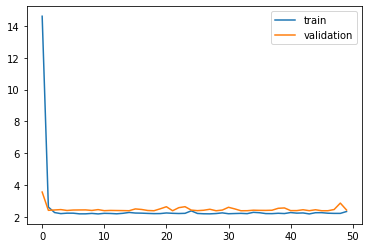

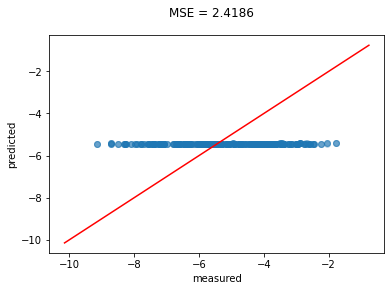

12. L = 12.8, sigma = 0.01, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1103.5918s.                               


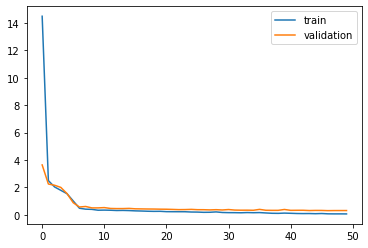

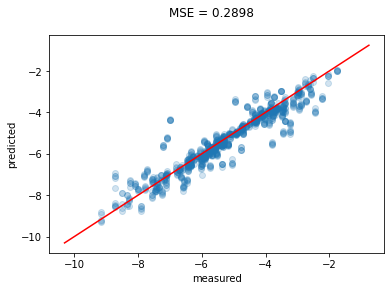

13. L = 12.8, sigma = 0.01, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1170.5835s.                               


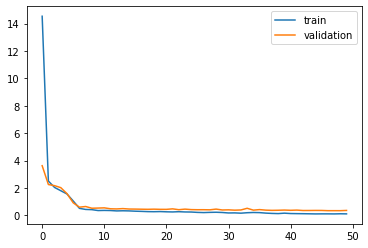

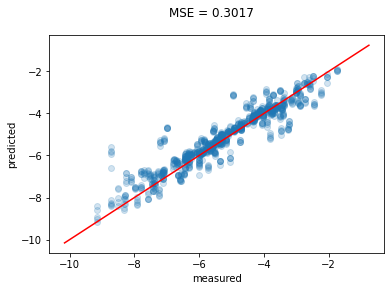

14. L = 12.8, sigma = 0.01, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1097.8554s.                               


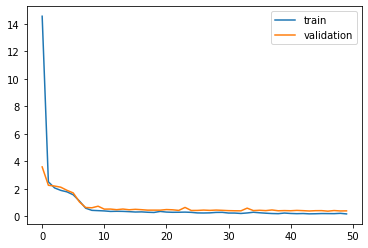

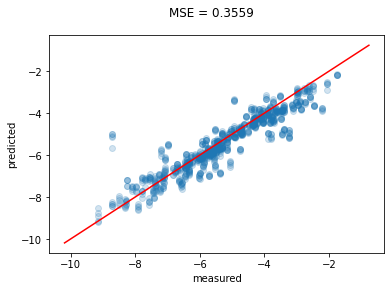

15. L = 12.8, sigma = 0.1, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1123.7222s.                               


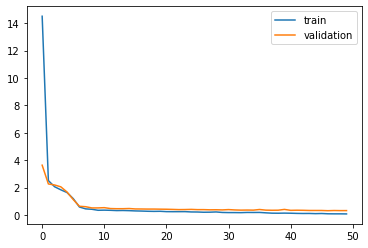

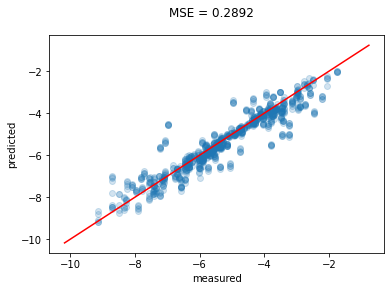

16. L = 12.8, sigma = 0.1, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1102.5760s.                               


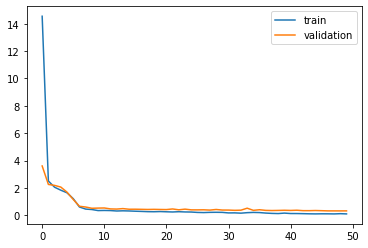

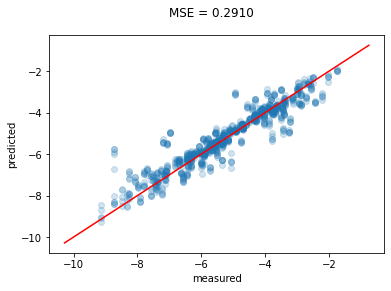

17. L = 12.8, sigma = 0.1, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1095.9946s.                               


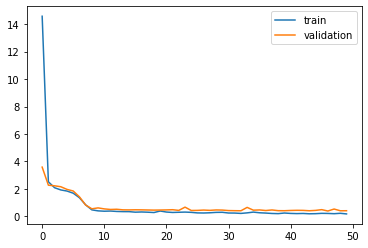

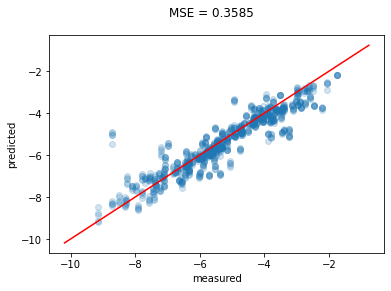

18. L = 12.8, sigma = 0.5, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1094.3541s.                               


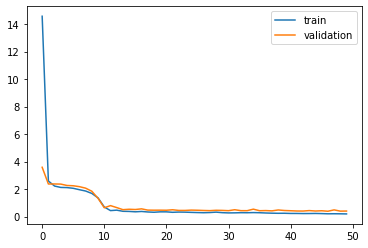

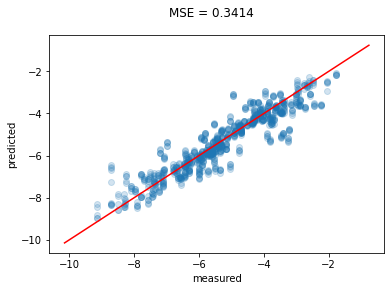

19. L = 12.8, sigma = 0.5, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1100.9688s.                               


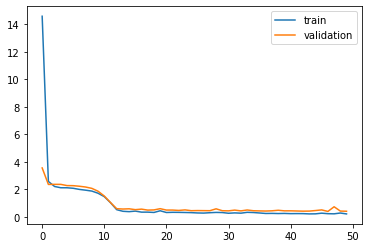

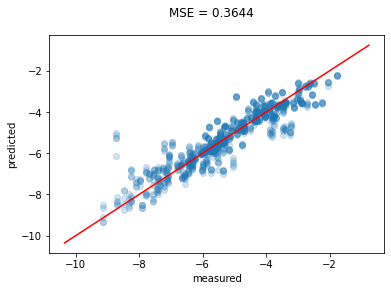

20. L = 12.8, sigma = 0.5, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1099.5953s.                               


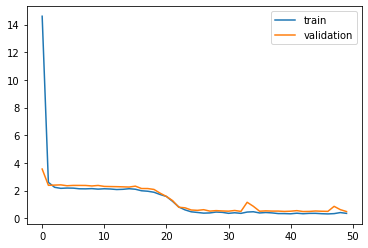

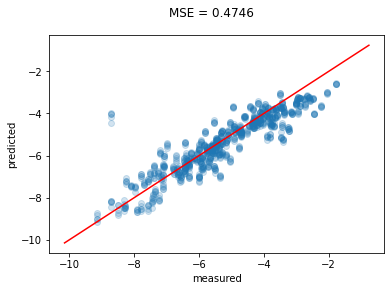

21. L = 12.8, sigma = 1.0, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1099.1659s.                               


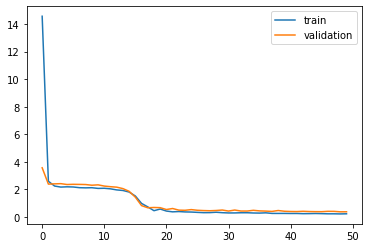

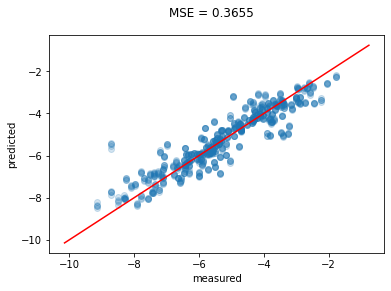

22. L = 12.8, sigma = 1.0, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1094.8846s.                               


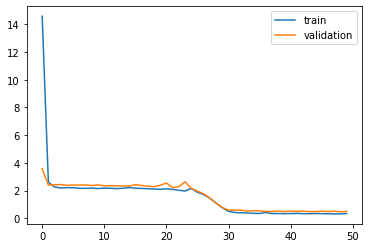

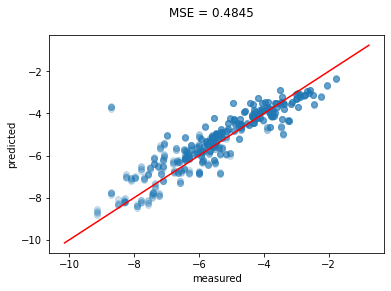

23. L = 12.8, sigma = 1.0, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 1101.1910s.                               


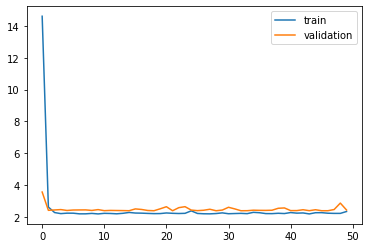

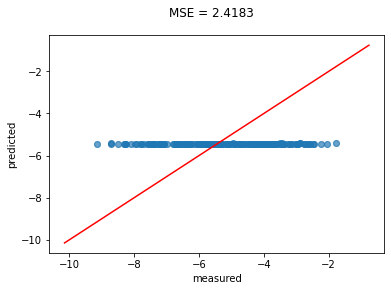

24. L = 15, sigma = 0.01, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 929.0464s.                               


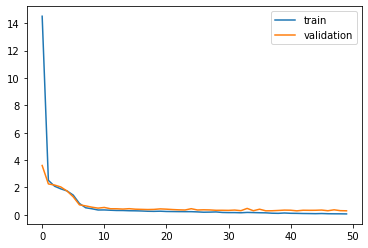

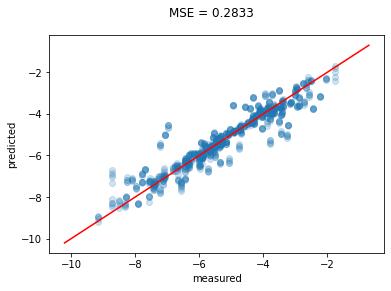

25. L = 15, sigma = 0.01, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 937.6469s.                               


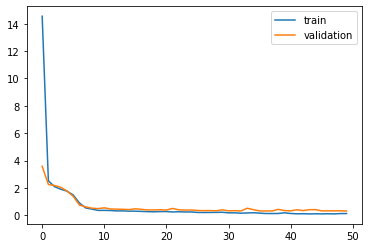

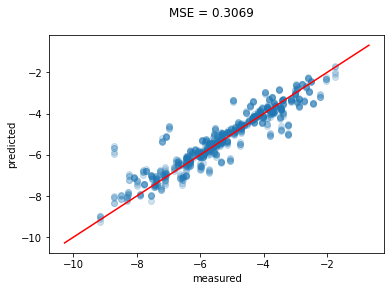

26. L = 15, sigma = 0.01, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.01, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.01, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 931.6153s.                               


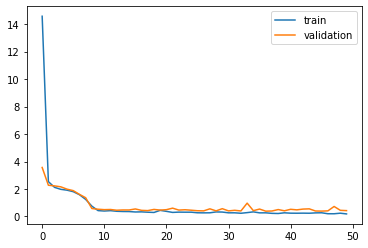

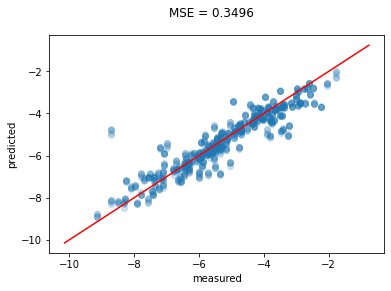

27. L = 15, sigma = 0.1, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 931.7101s.                               


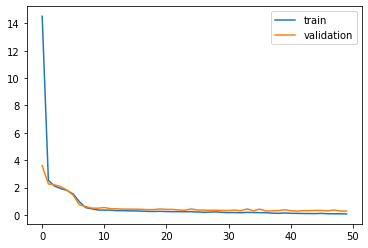

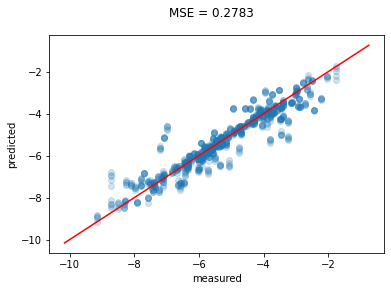

28. L = 15, sigma = 0.1, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 930.6683s.                               


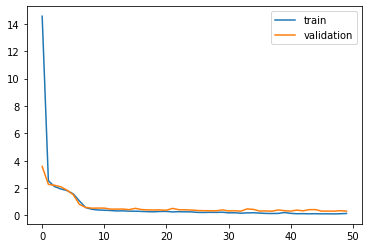

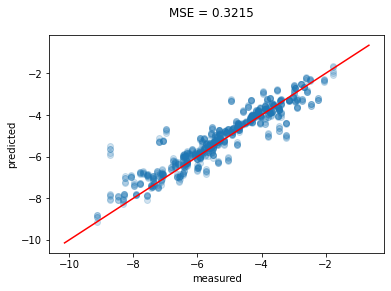

29. L = 15, sigma = 0.1, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 928.3393s.                               


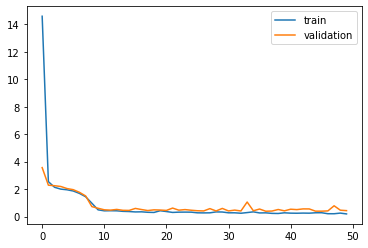

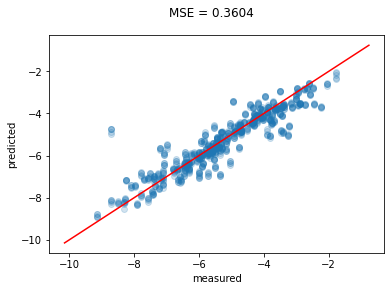

30. L = 15, sigma = 0.5, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 928.4174s.                               


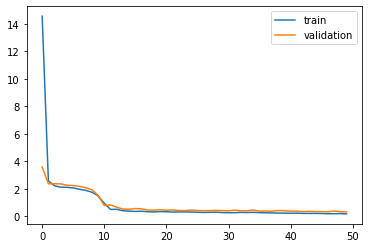

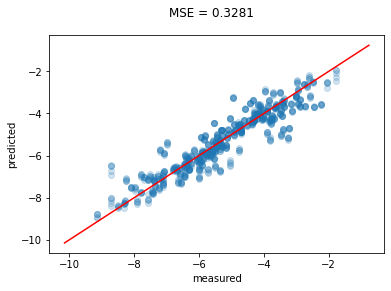

31. L = 15, sigma = 0.5, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 929.6407s.                               


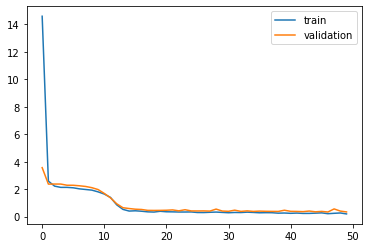

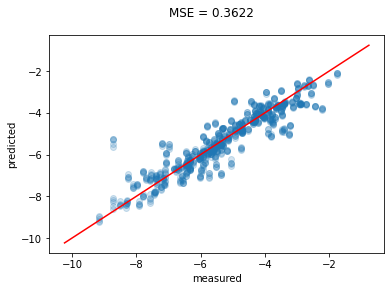

32. L = 15, sigma = 0.5, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 0.5, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.5, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 930.2278s.                               


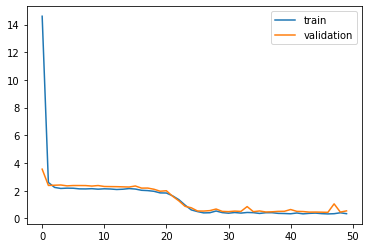

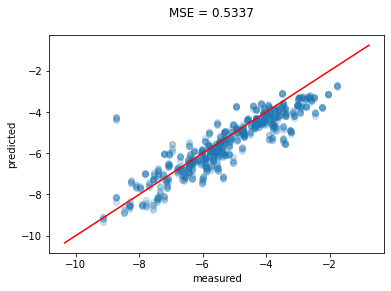

33. L = 15, sigma = 1.0, weight_decay = 0.0
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 929.2690s.                               


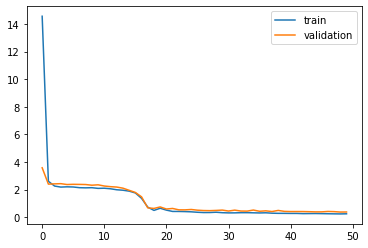

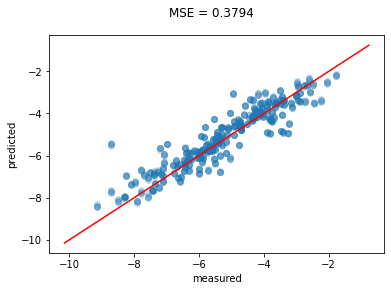

34. L = 15, sigma = 1.0, weight_decay = 0.001
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 927.8184s.                               


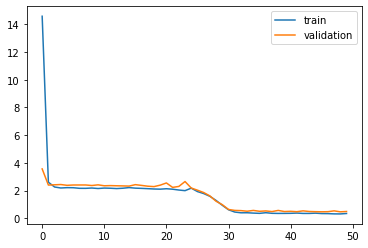

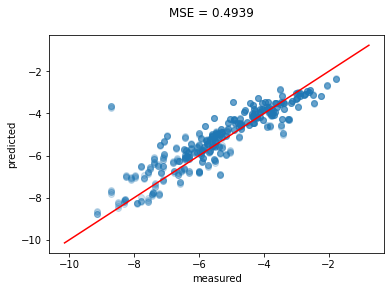

35. L = 15, sigma = 1.0, weight_decay = 0.01
Initialised MolLoader with 1784 molecules. sigma = 1.0, L=15, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 1.0, L=15, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Finished in 930.5026s.                               


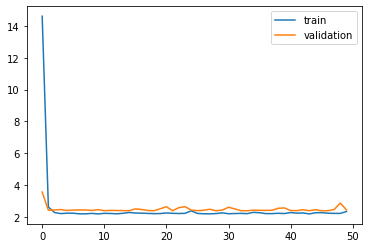

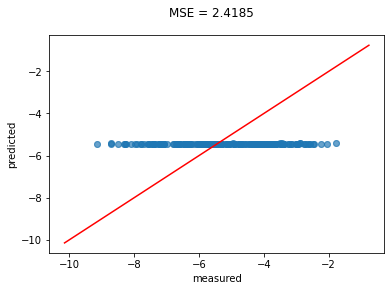

In [11]:
epochs = 50
N = 32

device = get_default_device()

results = []

for i, params in enumerate(param_grid):
    L = params["L"]
    sigma = params["sigma"]
    weight_decay = params["weight_decay"]
    print(f"{i}. L = {L}, sigma = {sigma}, weight_decay = {weight_decay}")

    seed_everything()
    
    net = VoxelNet(nchannel)
    net = net.to(device)

    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
                   L=L, N=N, batch_size=64, nchannel=nchannel,
                   shuffle=True, rotate_randomly=True, device=device, reduce_data=True)

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
                       L=L, N=N, batch_size=128, nchannel=nchannel,
                       shuffle=False, rotate_randomly=False, device=device, reduce_data=True)

    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=weight_decay, verbose=False)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    
    results.append(np.mean((ys - y_hats)**2))

In [15]:
for param, mse in zip(param_grid, results):
    print(param, mse)

{'L': 10, 'sigma': 0.01, 'weight_decay': 0.0} 0.28617975
{'L': 10, 'sigma': 0.01, 'weight_decay': 0.001} 0.2838946
{'L': 10, 'sigma': 0.01, 'weight_decay': 0.01} 0.3125895
{'L': 10, 'sigma': 0.1, 'weight_decay': 0.0} 0.28334868
{'L': 10, 'sigma': 0.1, 'weight_decay': 0.001} 0.29227042
{'L': 10, 'sigma': 0.1, 'weight_decay': 0.01} 0.32739392
{'L': 10, 'sigma': 0.5, 'weight_decay': 0.0} 0.3564456
{'L': 10, 'sigma': 0.5, 'weight_decay': 0.001} 0.3606634
{'L': 10, 'sigma': 0.5, 'weight_decay': 0.01} 0.47989318
{'L': 10, 'sigma': 1.0, 'weight_decay': 0.0} 0.3959534
{'L': 10, 'sigma': 1.0, 'weight_decay': 0.001} 0.46692675
{'L': 10, 'sigma': 1.0, 'weight_decay': 0.01} 2.418591
{'L': 12.8, 'sigma': 0.01, 'weight_decay': 0.0} 0.28981915
{'L': 12.8, 'sigma': 0.01, 'weight_decay': 0.001} 0.3017334
{'L': 12.8, 'sigma': 0.01, 'weight_decay': 0.01} 0.3559154
{'L': 12.8, 'sigma': 0.1, 'weight_decay': 0.0} 0.28920534
{'L': 12.8, 'sigma': 0.1, 'weight_decay': 0.001} 0.2910312
{'L': 12.8, 'sigma': 0.1,

In [14]:
amin = np.argmin(results)
param_grid[amin], results[amin]

({'weight_decay': 0.0, 'sigma': 0.1, 'L': 15}, 0.27828187)

##  Cartesian

(1784, 13) (199, 13)
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 14.510468482971191 val loss 3.635354518890381
Epoch 1: train loss 2.508193016052246 val loss 2.2641918659210205
Epoch 2: train loss 2.061154842376709 val loss 2.189910650253296
Epoch 3: train loss 1.8365164995193481 val loss 2.0548300743103027
Epoch 4: train loss 1.63783860206604 val loss 1.6771807670593262
Epoch 5: train loss 1.1953470706939697 val loss 1.1266553401947021
Epoch 6: train loss 0.5811874270439148 val loss 0.6347856521606445
Epoch 7: train loss 0.44517210125923157 val loss 0.6028158664703369
Epoch 8: train loss 0.4154815673828125 val loss 0.5135679244995117
Epoch 9: train loss 0.34222280979156494 val loss 0.514217734336853
Epoch 10: train loss 0.35156136751174927 val loss 0.5330494046211243


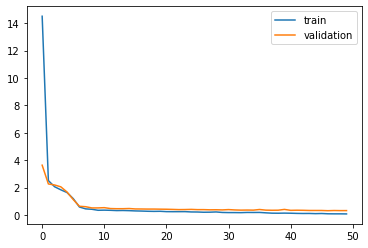

In [13]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='cartesian')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.00)

### Train Plots

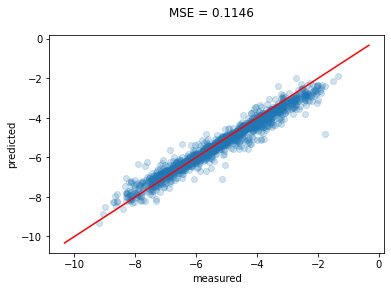

In [14]:
# 0.1146
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

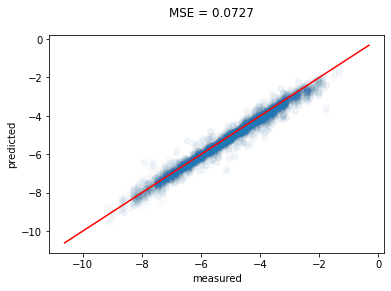

In [15]:
# 0.0727
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

### Test Plots

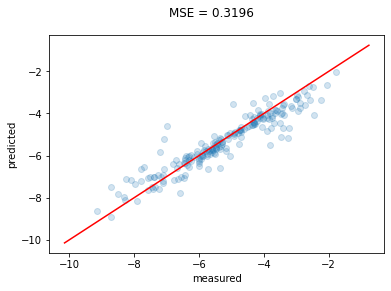

In [16]:
# 0.3196
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

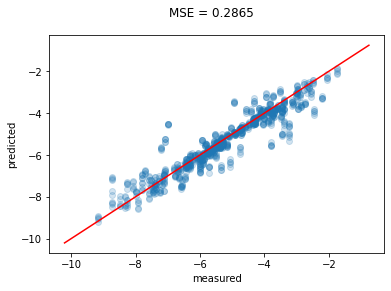

In [17]:
# 0.2865
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)

## Spherical

(1784, 13) (199, 13)
Initialised MolLoader with 1784 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 199 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 14.495903015136719 val loss 3.6274428367614746
Epoch 1: train loss 2.424748420715332 val loss 2.091684103012085
Epoch 2: train loss 1.8681421279907227 val loss 1.8386657238006592
Epoch 3: train loss 1.4519411325454712 val loss 1.3384039402008057
Epoch 4: train loss 0.832569420337677 val loss 0.5795411467552185
Epoch 5: train loss 0.40135955810546875 val loss 0.5261200666427612
Epoch 6: train loss 0.3555009663105011 val loss 0.47415974736213684
Epoch 7: train loss 0.361759752035141 val loss 0.4501400291919708
Epoch 8: train loss 0.3627378046512604 val loss 0.4978748857975006
Epoch 9: train loss 0.326205313205719 val loss 0.4170578122138977
Epoch 10: train loss 0.32282063364982605 val loss 0.422897875308990

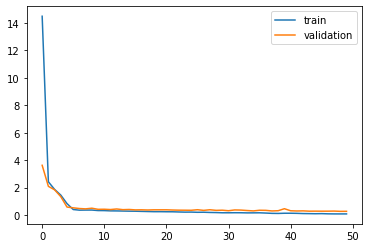

In [8]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()


seed_everything()
train_df, test_df = train_test_split(df, test_size=0.1)
print(train_df.shape, test_df.shape)

seed_everything()

net = VoxelNet(nchannel)
net = net.to(device)

ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, reduce_data=True, mode='spherical')

ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, reduce_data=True, mode='spherical')

fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0.00)

### Train Plots

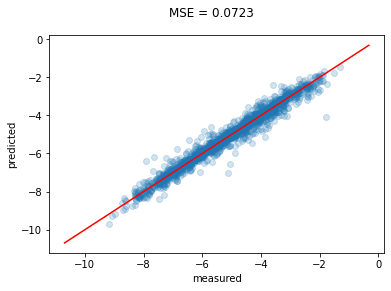

In [9]:
# 0.0723
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

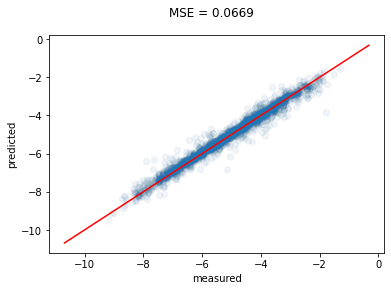

In [10]:
# 0.0669
# rotations
seed_everything()
ml_pred = ml_train
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

In [ ]:
seed_everything()
ml_wrong_mode_pred = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=True, device=device, reduce_data=True, mode='cartesian')
ys, y_hats = predict_epochs(net, ml_wrong_mode_pred, epochs=5)
plot_predictions(ys, y_hats, alpha=0.01)

### Test Plots

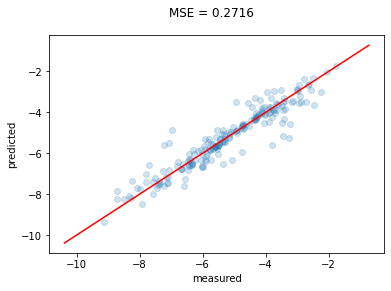

In [11]:
# 0.2716
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=False)
ys, y_hats = predict(net, ml_pred)
plot_predictions(ys, y_hats)

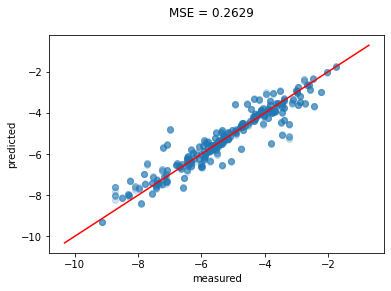

In [12]:
# 0.2629
# rotations
seed_everything()
ml_pred = ml_test
ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
plot_predictions(ys, y_hats)

## Cross Validation

### Cartesian

Initialised MolLoader with 1586 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 16.24565887451172 val loss 2.1516387462615967
Epoch 1: train loss 2.663943290710449 val loss 2.35333251953125
Epoch 2: train loss 2.122293472290039 val loss 1.9715882539749146
Epoch 3: train loss 1.9249932765960693 val loss 1.8508683443069458
Epoch 4: train loss 1.770640254020691 val loss 1.7544769048690796
Epoch 5: train loss 1.5405220985412598 val loss 1.396796464920044
Epoch 6: train loss 1.049458622932434 val loss 0.8681060075759888
Epoch 7: train loss 0.5145994424819946 val loss 0.5064305067062378
Epoch 8: train loss 0.3941229283809662 val loss 0.46598878502845764
Epoch 9: train loss 0.3745250403881073 val loss 0.44581830501556396
Epoch 10: train loss 0.3591041564941406 val loss 0.49580782651901245
Epoch 11: train loss 0

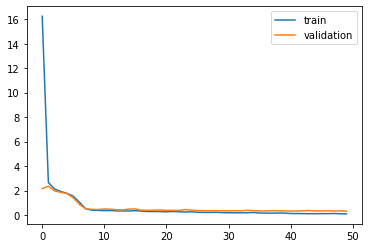

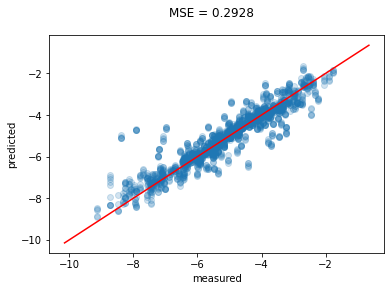

Initialised MolLoader with 1586 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 13.660362243652344 val loss 3.5870108604431152
Epoch 1: train loss 2.7218594551086426 val loss 2.468853712081909
Epoch 2: train loss 2.0829358100891113 val loss 2.139768600463867
Epoch 3: train loss 1.8854552507400513 val loss 2.0022950172424316
Epoch 4: train loss 1.7634378671646118 val loss 2.1204543113708496
Epoch 5: train loss 1.4776097536087036 val loss 1.47160005569458
Epoch 6: train loss 0.9848889708518982 val loss 0.7742733955383301
Epoch 7: train loss 0.520629346370697 val loss 0.465799480676651
Epoch 8: train loss 0.4215715229511261 val loss 0.4789358079433441
Epoch 9: train loss 0.43931859731674194 val loss 0.4518810510635376
Epoch 10: train loss 0.3697359263896942 val loss 0.42214369773864746
Epoch 11: train loss 

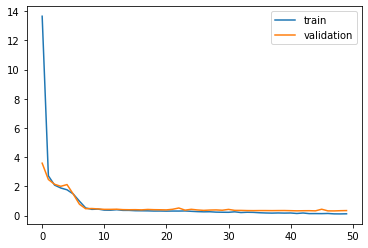

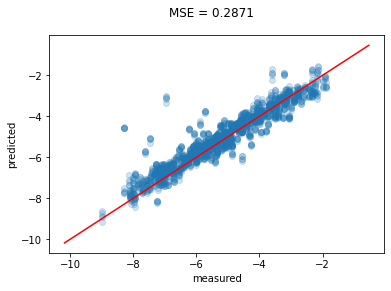

Initialised MolLoader with 1586 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 12.792449951171875 val loss 2.849392890930176
Epoch 1: train loss 2.575955390930176 val loss 2.1355180740356445
Epoch 2: train loss 2.070754051208496 val loss 2.019505023956299
Epoch 3: train loss 1.9620414972305298 val loss 1.878426432609558
Epoch 4: train loss 1.732452392578125 val loss 1.5554378032684326
Epoch 5: train loss 1.15827214717865 val loss 1.0968217849731445
Epoch 6: train loss 0.5507106184959412 val loss 0.6411380171775818
Epoch 7: train loss 0.47498804330825806 val loss 0.5246427655220032
Epoch 8: train loss 0.3759878873825073 val loss 0.5355981588363647
Epoch 9: train loss 0.35984399914741516 val loss 0.5364555716514587
Epoch 10: train loss 0.3665004372596741 val loss 0.4843914210796356
Epoch 11: train loss 0.

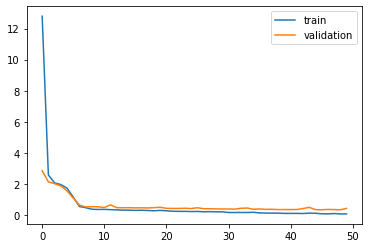

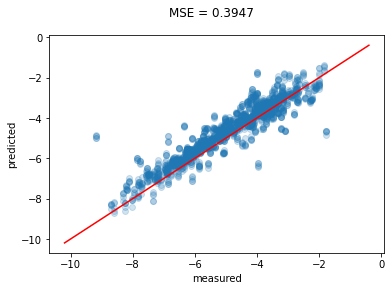

Initialised MolLoader with 1587 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 14.779470443725586 val loss 4.508687496185303
Epoch 1: train loss 2.440229654312134 val loss 2.125690460205078
Epoch 2: train loss 1.9690260887145996 val loss 1.9422118663787842
Epoch 3: train loss 1.7881062030792236 val loss 1.7859106063842773
Epoch 4: train loss 1.4833070039749146 val loss 1.3387367725372314
Epoch 5: train loss 0.9208982586860657 val loss 0.7368855476379395
Epoch 6: train loss 0.4794928729534149 val loss 0.6604105830192566
Epoch 7: train loss 0.40434664487838745 val loss 0.5081334114074707
Epoch 8: train loss 0.35422804951667786 val loss 0.5609456300735474
Epoch 9: train loss 0.36349916458129883 val loss 0.47056064009666443
Epoch 10: train loss 0.33034026622772217 val loss 0.43127235770225525
Epoch 11: trai

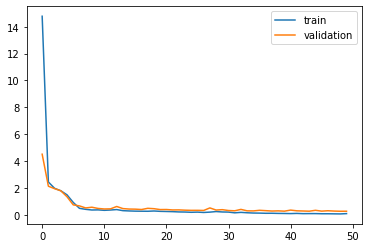

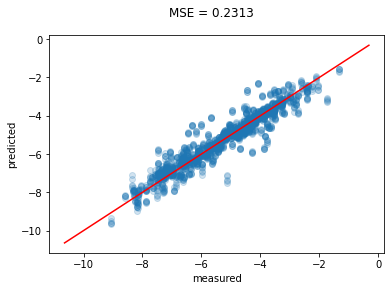

Initialised MolLoader with 1587 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 molecules. sigma = 0.1, L=12.8, N=32, nchannel=79, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 17.845294952392578 val loss 2.075300931930542
Epoch 1: train loss 2.498242139816284 val loss 2.071211099624634
Epoch 2: train loss 2.0715880393981934 val loss 1.9455680847167969
Epoch 3: train loss 1.9261043071746826 val loss 1.7876839637756348
Epoch 4: train loss 1.7608379125595093 val loss 1.6363626718521118
Epoch 5: train loss 1.5011646747589111 val loss 1.3998881578445435
Epoch 6: train loss 1.0376001596450806 val loss 0.8227436542510986
Epoch 7: train loss 0.5474491119384766 val loss 0.491530179977417
Epoch 8: train loss 0.4144054353237152 val loss 0.47150591015815735
Epoch 9: train loss 0.39886751770973206 val loss 0.45566073060035706
Epoch 10: train loss 0.3635701835155487 val loss 0.4920945167541504
Epoch 11: train lo

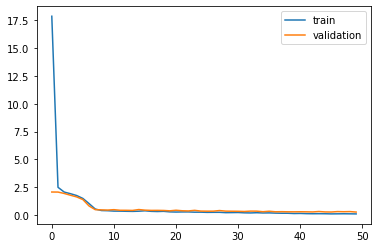

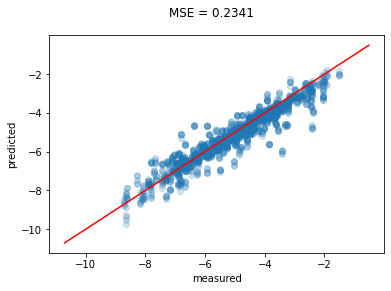

In [24]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device)

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device)
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    
    all_ys.append(ys)
    all_y_hats.append(y_hats)

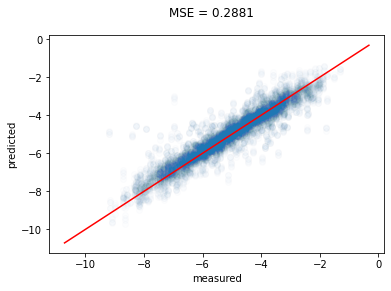

In [25]:
# 0.2881
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)

### Spherical

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 16.233394622802734 val loss 2.1190712451934814
Epoch 1: train loss 2.608797788619995 val loss 2.234229326248169
Epoch 2: train loss 1.967237114906311 val loss 1.7214365005493164
Epoch 3: train loss 1.6500095129013062 val loss 1.4288361072540283
Epoch 4: train loss 1.2601234912872314 val loss 0.9699004292488098
Epoch 5: train loss 0.6769126653671265 val loss 0.4690878987312317
Epoch 6: train loss 0.4038466215133667 val loss 0.4193010628223419
Epoch 7: train loss 0.3599322438240051 val loss 0.46812164783477783
Epoch 8: train loss 0.37396278977394104 val loss 0.39063629508018494
Epoch 9: train loss 0.3310752511024475 val loss 0.39217400550842285
Epoch 10: train loss 0.33721649646759033 val los

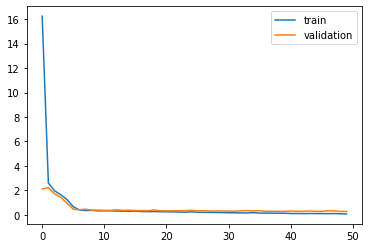

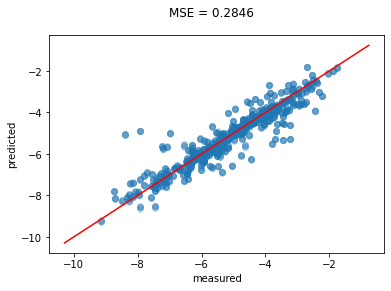

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 13.618256568908691 val loss 3.6142969131469727
Epoch 1: train loss 2.6553471088409424 val loss 2.2990784645080566
Epoch 2: train loss 1.9148091077804565 val loss 1.8695552349090576
Epoch 3: train loss 1.5911998748779297 val loss 1.4858845472335815
Epoch 4: train loss 1.166477918624878 val loss 0.9052272439002991
Epoch 5: train loss 0.5842642784118652 val loss 0.4176601469516754
Epoch 6: train loss 0.4201160967350006 val loss 0.37910857796669006
Epoch 7: train loss 0.3924080729484558 val loss 0.36732351779937744
Epoch 8: train loss 0.3670838177204132 val loss 0.36963343620300293
Epoch 9: train loss 0.3751603960990906 val loss 0.34519121050834656
Epoch 10: train loss 0.34582364559173584 val l

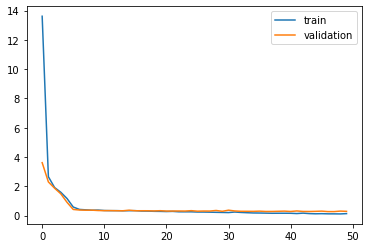

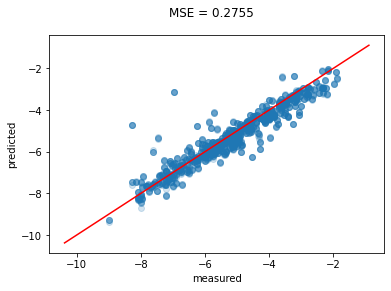

Initialised MolLoader with 1586 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 397 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 12.771215438842773 val loss 2.8561818599700928
Epoch 1: train loss 2.517423391342163 val loss 2.021002769470215
Epoch 2: train loss 1.9301584959030151 val loss 1.7924503087997437
Epoch 3: train loss 1.6469757556915283 val loss 1.3118855953216553
Epoch 4: train loss 0.9381991624832153 val loss 0.5219566822052002
Epoch 5: train loss 0.4187954068183899 val loss 0.5225590467453003
Epoch 6: train loss 0.36419254541397095 val loss 0.4454557001590729
Epoch 7: train loss 0.34991586208343506 val loss 0.4562069773674011
Epoch 8: train loss 0.34121906757354736 val loss 0.44786831736564636
Epoch 9: train loss 0.3311134874820709 val loss 0.47299250960350037
Epoch 10: train loss 0.34236279129981995 val l

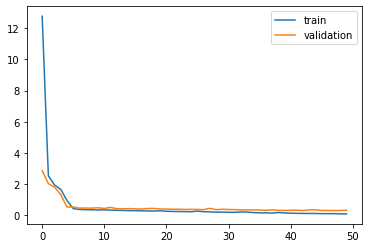

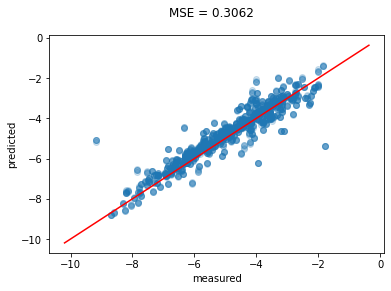

Initialised MolLoader with 1587 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 14.731253623962402 val loss 4.502273082733154
Epoch 1: train loss 2.3475794792175293 val loss 1.9106441736221313
Epoch 2: train loss 1.743567705154419 val loss 1.5391676425933838
Epoch 3: train loss 1.295526146888733 val loss 0.9471350908279419
Epoch 4: train loss 0.6504141092300415 val loss 0.43914994597435
Epoch 5: train loss 0.3919930160045624 val loss 0.42286866903305054
Epoch 6: train loss 0.37347251176834106 val loss 0.4000961184501648
Epoch 7: train loss 0.33834943175315857 val loss 0.3928721249103546
Epoch 8: train loss 0.35383686423301697 val loss 0.39233145117759705
Epoch 9: train loss 0.3369460701942444 val loss 0.4014400243759155
Epoch 10: train loss 0.3148321509361267 val loss 

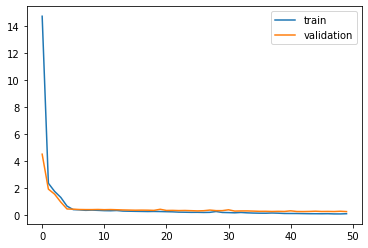

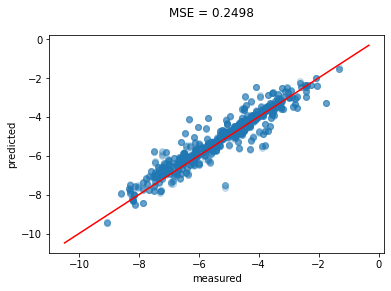

Initialised MolLoader with 1587 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=True, rotate=True, device=cuda
Initialised MolLoader with 396 compounds.
    sigma=0.1, L=12.8, N=32, nchannel=79, mode=spherical, shuffle=False, rotate=False, device=cuda
Epoch 0: train loss 17.817264556884766 val loss 2.0383102893829346
Epoch 1: train loss 2.4339890480041504 val loss 1.9610928297042847
Epoch 2: train loss 1.8973445892333984 val loss 1.7186919450759888
Epoch 3: train loss 1.6131486892700195 val loss 1.3813865184783936
Epoch 4: train loss 1.2372251749038696 val loss 0.9110693335533142
Epoch 5: train loss 0.621747612953186 val loss 0.4352455139160156
Epoch 6: train loss 0.41397151350975037 val loss 0.3909411132335663
Epoch 7: train loss 0.36740365624427795 val loss 0.37909752130508423
Epoch 8: train loss 0.3512824475765228 val loss 0.3746887445449829
Epoch 9: train loss 0.3580473065376282 val loss 0.3932126760482788
Epoch 10: train loss 0.33981791138648987 val lo

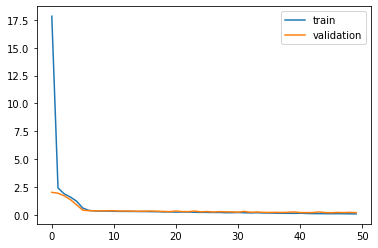

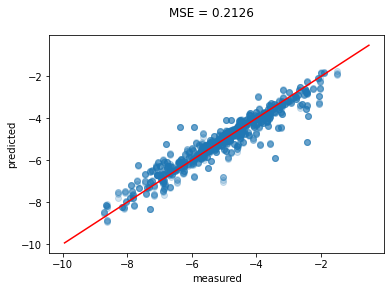

In [8]:
sigma = 0.1
L = 12.8
N = 32
epochs = 50
device = get_default_device()

seed_everything()
all_ys = []
all_y_hats = []

for train_indices, test_indices in KFold(n_splits=5, shuffle=True).split(df):
    
    train_df = df.iloc[train_indices]
    test_df = df.iloc[test_indices]

    net = VoxelNet(nchannel)
    net = net.to(device)
    
    ml_train = MolLoader(train_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=64, nchannel=nchannel,
               shuffle=True, rotate_randomly=True, device=device, mode='spherical')

    ml_test = MolLoader(test_df, sigma=sigma, elements=elements,
               L=L, N=N, batch_size=128, nchannel=nchannel,
               shuffle=False, rotate_randomly=False, device=device, mode='spherical')
    
    fit(epochs, net, ml_train, ml_test, torch.optim.Adam, lr=0.001, weight_decay=0)
    
    ml_pred = ml_test
    ml_pred.reset(batch_size=128, shuffle=False, rotate_randomly=True)
    ys, y_hats = predict_epochs(net, ml_pred, epochs=5)
    plot_predictions(ys, y_hats)
    
    all_ys.append(ys)
    all_y_hats.append(y_hats)

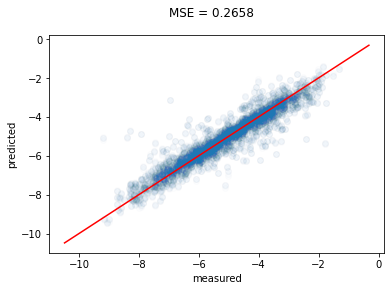

In [9]:
# 0.2658
plot_predictions(np.hstack(all_ys), np.hstack(all_y_hats), alpha=0.01)